<a href="https://colab.research.google.com/github/bjentwistle/PythonFundamentals/blob/main/Projects/Final_Movies_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movies project
---

In a previous session we  converted an SQL relational database to a single pandas dataframe and downloaded it. I wanted to incorporate that work within this data analysis project to show the process.

---
Data is sourced from here [IMDb dataset](https://relational.fit.cvut.cz/dataset/IMDb)
IMDb stands for the Internet Movie Database and it's a huge relational repository of all movies, video games and  TV shows, directors, actors and cinematographers etc. Basically, anything to do with the entertainment business can be searched for on IMDB, if you like a film and want to see what other movies that director has done, or you want to know more about the main actors in movies, it's all there going back to 1892!


Internet Movie Database (IMDb) layout we will use.
---
[image source](https://relational.fit.cvut.cz/assets/img/datasets-generated/imdb_ijs.svg)

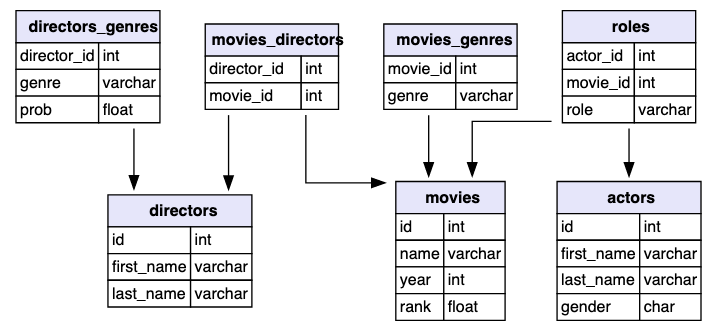

First  we must install MySQL converter.

In [64]:
!pip install mysql.connector

From the source site we have to use following credentials to access the dataset:

    hostname: relational.fit.cvut.cz
    port: 3306
    username: guest
    password: relational

Then we can run the query to retrieve the data.

In [65]:
import mysql.connector

# add the database configuration code here
mydb = mysql.connector.connect(
  host="relational.fit.cvut.cz",
  port="3306",
  user ="guest",
  password ="relational",
  database="imdb_ijs"    
)

# add a function to execute a query 
def execute_query(query):
  mycursor = mydb.cursor()
  mycursor.execute(query)
  try:
    records = mycursor.fetchall()
    return records
  except:
    print("An error occurred: ")
    return None


# run a query using the execute query function
records = execute_query("SHOW TABLES")

for record in records:
  query = ("SELECT COUNT(*) FROM " + record[0])
  results = execute_query(query)
  print(record, "=", results)

('actors',) = [(817718,)]
('directors',) = [(86880,)]
('directors_genres',) = [(156562,)]
('movies',) = [(388269,)]
('movies_directors',) = [(371180,)]
('movies_genres',) = [(395119,)]
('roles',) = [(3431966,)]


Next step is to read the data we have retrieved into a pandas dataframe so we can play with it. 

In [66]:
import pandas as pd
from google.colab import files

#Function to get the data from csv format into a dataframe we can use.
def get_movies_data():
  query = "SELECT first_name, last_name, name, year, rank, genre FROM directors, movies, movies_genres, movies_directors WHERE movies.id = movies_directors.movie_id AND movies.id = movies_genres.movie_id AND directors.id = movies_directors.director_id"
  movies_df = pd.read_sql_query(query, mydb)
  movies_df.to_csv('movies.csv')
  files.download('movies.csv')
  return movies_df

# This code will test if the movies_df variable is a valid pandas dataframe 
movies_df = get_movies_data()
if isinstance(movies_df,pd.DataFrame):
  print("Test passed, variable is a pandas dataframe")
else:
  print("Test failed, not a pandas dataframe")

# This will show the first part of the dataframe
movies_df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test passed, variable is a pandas dataframe


,first_name,last_name,name,year,rank,genre
0,Les,12 Poissons,Rondo pour trompette,2002,NaN,Short
1,Lejaren,a'Hiller,"Sleep of Cyma Roget, The",1920,NaN,Drama
2,Khairiya,A-Mansour,Churches in Iraq,1988,NaN,Documentary
3,Ricardo,A. Solla,"Foto, La",2001,NaN,Drama
4,Ricardo,A. Solla,"Foto, La",2001,NaN,Short


### Inspect the dataset 
---

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Show the top of the dataframe to check it is as you expect
movies_df.head()

,first_name,last_name,name,year,rank,genre
0,Les,12 Poissons,Rondo pour trompette,2002,NaN,Short
1,Lejaren,a'Hiller,"Sleep of Cyma Roget, The",1920,NaN,Drama
2,Khairiya,A-Mansour,Churches in Iraq,1988,NaN,Documentary
3,Ricardo,A. Solla,"Foto, La",2001,NaN,Drama
4,Ricardo,A. Solla,"Foto, La",2001,NaN,Short


The dataset contains 6 columns of data.

If using the link above then there is a first column which is not needed so you can remove it in the next code box by uncommenting the .drop line.

**first_name** is the first name of the director.
**last_name** is their surname.
**name** is for the movie's name.
**year** is the year the movie was released.
**rank** is the mean star rating out of 10 that viewers have given this movie.
**genre** refers to the movie genre that they film belongs to. Some movies belong in several genres so there are duplicates in the movie name column to be dealt with later.

### Clean the dataset 
---


In [68]:
df_cleaned = movies_df
df_cleaned= df_cleaned.dropna()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113376 entries, 77 to 368891
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   first_name  113376 non-null  object 
 1   last_name   113376 non-null  object 
 2   name        113376 non-null  object 
 3   year        113376 non-null  int64  
 4   rank        113376 non-null  float64
 5   genre       113376 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.1+ MB


### Ideas for cleaning the data


1.   Remove the unnamed column as it is just an index that not needed.
2.   Make sure that there are no spaces " " in the columns
3. Sort by genre or year.
4. Remove films with no ranking - to reduce the size.

### I decided only rank column needed to be cleaned up as that is the only numerical data needed for statistics.








### How many movies of each genre are there?
---

In [69]:
#Using the full dataframe to get numbers of films per genre (there are overlaps as one film has many genres)
#Hence why drop duplicates (name)is used further down.
genres = movies_df["genre"].value_counts()

print(genres)

Short          72894
Drama          72635
Comedy         54667
Documentary    35698
Animation      17038
Romance        13562
Action         12890
Crime          12610
Family         11074
Thriller       10681
Adventure       8598
Western         8231
Horror          7423
Musical         6843
Sci-Fi          4957
Mystery         4951
Fantasy         4871
Music           4444
War             4398
Film-Noir        429
Name: genre, dtype: int64


### Which director has the highest ranked movies?
---

In [70]:
def clean_names(df):
  # drop duplicates of movie name as many genres are associated with one film
  directors = df.drop_duplicates(["name"])
  #Create a new column with full name of director from first and last. 
  directors["fullname"] = df["first_name"] + " " + df["last_name"]
  directors = directors.drop(columns = ["first_name", "last_name"])
  return directors

directors = clean_names(df_cleaned)

#find the average rating of each director and then sort descending.
def top_directors(df):
  directors_rank = df.groupby(["fullname"])["rank"].mean()
  directors_rank = directors_rank.sort_values(ascending = False)
  print(directors_rank.head(10))

top_directors(directors)

fullname
Arünas Zebriünas       9.9
William T. Hurtz       9.9
Scott Barkan           9.9
Matthew Crandall       9.9
Kirsten Tretbar        9.9
Andrew Cappelletti     9.9
Debs Tarrier           9.9
Djordje Kadijevic      9.8
François Miron         9.8
Takis Kanellopoulos    9.8
Name: rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### How many movies have ranks of over 9?
---


In [71]:
#Dropped duplicates of movie names as they have multiple entries due to genre column.
df_dropdups = df_cleaned.drop_duplicates(["name"])
top_movie_count = df_dropdups[df_dropdups["rank"] >= 9].count()   
print("Count of movies with ranking 9 or above is:", top_movie_count[5])

Count of movies with ranking 9 or above is: 1021


### Plot a bar chart of median rank and genre
---

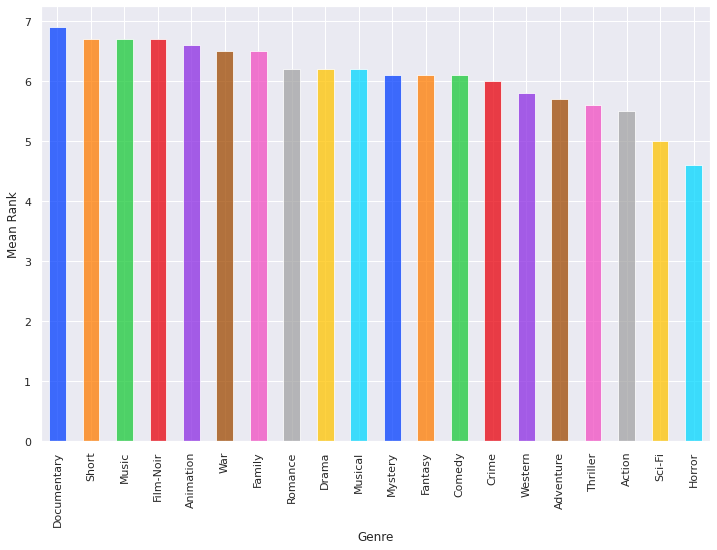

In [72]:
#Used median rating here as the most frequent rating is most likely the most representative for a film, the rating is subjective.

def plot_barchart(df):
  rank_by_genre = df.groupby('genre')['rank'].median()
  rank_by_genre = rank_by_genre.sort_values( ascending = False)
  sns.set(rc={'figure.figsize':(12,8)})
  colors = sns.color_palette('bright')
  bar_plot = rank_by_genre.plot(x="genre", y=rank_by_genre, kind="bar", alpha=0.75, rot=90, color = colors)
  bar_plot.set_xlabel("Genre")
  bar_plot.set_ylabel("Mean Rank");


plot_barchart(df_cleaned)

### Plot a pie chart of how many movies of each genre there are 
---


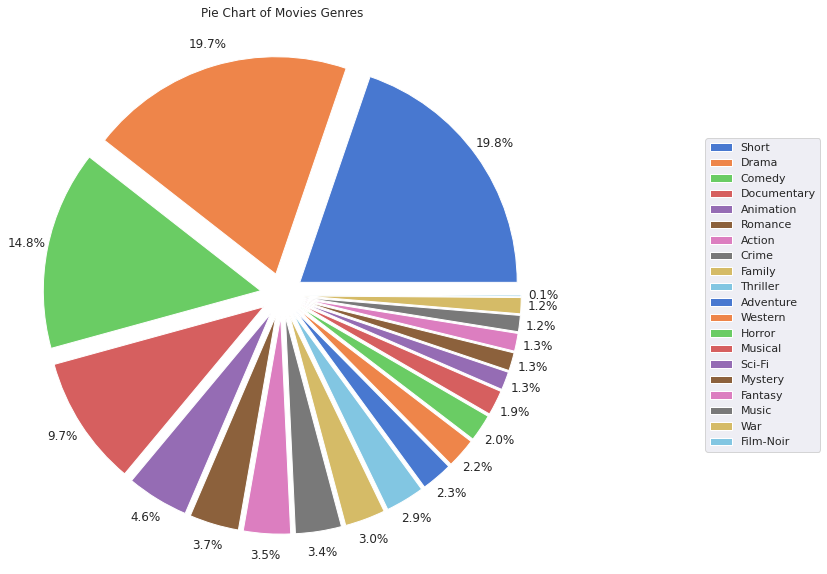

In [73]:
#Plot a Pie chart of genres of films and their percentages.

def plot_piechart(df):
  count_by_genre = df.groupby('genre')['rank'].count()
  count_by_genre = count_by_genre.sort_values( ascending = False)
  colors = sns.color_palette('muted')
  labels = genres.keys()
  sns.set(rc={'figure.figsize':(10,10)})
  explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
  plt.pie(genres, colors = colors, pctdistance=1.1, labeldistance=1.2, explode = explode, autopct='%1.1f%%')
  plt.title("Pie Chart of Movies Genres")
  plt.legend(labels, bbox_to_anchor=(1.5,0.5), loc="right")
  plt.show()

plot_piechart(df_cleaned)

### Plot a graph showing the mean Rank for each year 

First year =  1892
Last year =  2004


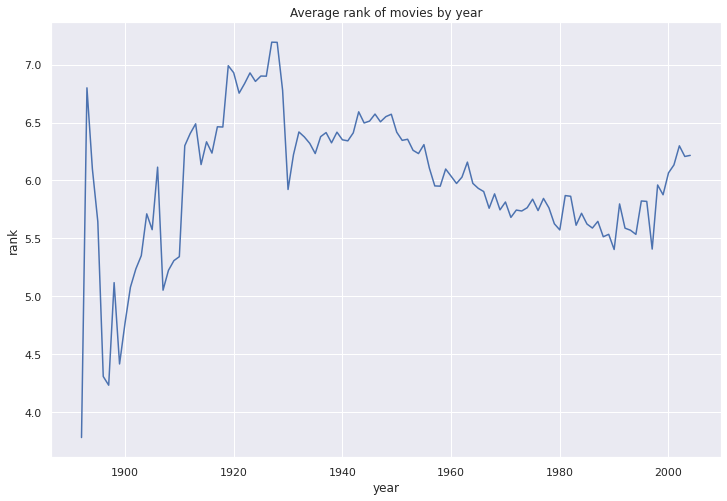

In [107]:
rank_by_year = df_cleaned.groupby('year')['rank'].mean()
#print(rank_by_year)
#plot the chart of the data means 
def draw_line(data):
  sns.set(rc={'figure.figsize':(12,8)})
  chart = sns.lineplot(data=data, palette = "blue")
  plt.title("Average rank of movies by year")
  sns.set_style("whitegrid")

draw_line(rank_by_year)

#Small function to print out the maximum and minimum values of a given column.
def get_maxandmin(df,column): 
  print("First year = ", df[column].min())
  print("Last year = " , df[column].max())

get_maxandmin(df_cleaned,"year")

### This graph shows the highest ranked movies were made in the 1920's 🤩 One of my favourite eras of movie history.

### What else can you find out from this dataset?
---
We made a plan of further things we would do to interrogate and analyse this dataset:- 

1.  Try ranking the directors by rating but also number of movies made. (extra challenge - find highest ranked director by genre)
2.  write a function to return list of movies for a given director.
3.  return a count of list of modern movies > 2000 to compare with Jay's count of movies released before 2000.
4. plot total number of movies each year.

Task 1 is based on Jay's original workings, though I will try to incorporate it into my code.

In [75]:
import matplotlib.pyplot as plt

#Task 1 - Rank the directors by their movie ratings and the number of movies they have directed.
#Take a copy of the df with all non values dropped.
directors = df_cleaned

#First create a new column with fullname in - concatenated from two columns, then remove the original columns.
directors["fullname"] = directors["first_name"] + " " + directors["last_name"]
directors = directors.drop(columns = ["first_name", "last_name"])
directors_name = directors["fullname"]
directors.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 113376 entries, 77 to 368891
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   name      113376 non-null  object 
 1   year      113376 non-null  int64  
 2   rank      113376 non-null  float64
 3   genre     113376 non-null  object 
 4   fullname  113376 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 9.2+ MB


In [76]:
#Now create a dataframe from the directors df and include the statistics on their rankings.
def make_dataframe(df):
  #group the directors ranks by their fullnames.
  directors_rank_ave = df.groupby(["fullname"])["rank"].mean()
  #print(directors_rank_ave) #check to see a number is returned
  directors_rank_median = df.groupby(["fullname"])["rank"].median()
  #print(directors_rank_median) #check to see a number is returned
  directors_movie_names = directors.groupby(["fullname"])["name"]
  directors_movie_count = directors_movie_names.count() 

  #create new dataframe with above statistics from df_filtered.
  directors_movie_names_series = pd.Series(directors_movie_names)
  directors_rank_ave_series = pd.Series(directors_rank_ave)
  directors_rank_median_series = pd.Series(directors_rank_median)
  directors_movie_count_series = pd.Series(directors_movie_count)

  frame = {"Directors average rank": directors_rank_ave_series, "Directors median rank": directors_rank_median_series, "Directors movie total": directors_movie_count_series }
  new_dataframe =  pd.DataFrame(frame)
  
  return(new_dataframe)

new_dataframe = make_dataframe(directors)

new_dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 22104 entries, 'Philthy' Phil Phillips to Þráinn Bertelsson
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Directors average rank  22104 non-null  float64
 1   Directors median rank   22104 non-null  float64
 2   Directors movie total   22104 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 690.8+ KB


In [77]:
#sort by rank and count of movies
top_directors = new_dataframe.sort_values(["Directors movie total", "Directors average rank"], ascending = (False, False))
top_directors.head(10)

,Directors average rank,Directors median rank,Directors movie total
fullname,,,
Friz Freleng,6.718341,6.8,1025
Chuck (I) Jones,6.944614,7.0,984
Dave Fleischer,5.974526,5.9,738
Robert McKimson,6.475897,6.5,697
Tex Avery,7.029077,6.9,509
William (I) Hanna,6.518496,6.6,492
Joseph Barbera,6.538763,6.6,485
Robert Clampett,7.181212,7.1,330
Jack Kinney,6.591829,6.5,257


The top director is here Friz Freleng according to my code. I didn't know who he was and how he had made so many movies. So I looked him up on IMDB and he has made most of the Looney Tunes cartoons and many others in his long career.
[Friz Freleng on IMDB](https://www.imdb.com/name/nm0293989/?ref_=fn_al_nm_1)

This next function asks the user for a genre they would like to see the top directors for. Once they choose, the function returns the top 10 in the database ranked by their average rank then by the number of movies they have made.

In [97]:
#Created a function to filter the original df by genre input by the user, then run the function from above to 
#create a new df with mean and count of movies on just one genre. While loop ensures the user inputs a valid genre.

def filtered_by_genre(df):
  print(genres.index) #shows the user the different genres they can choose from.
  genre = None
  while genre == None:
    #Ask the user to choose a genre they wish to see the top directors in.
    genre = input("Input a genre from above list(case sensitive): ").title() #forces the input to change to Title format to avoid NaN output
    if genres.index.any() == genre:
      filtered_df = df[df['genre'] == genre]  
      #create a new dataframe from the genre filtered data and display it sorted for the user.      
      new_dataframe = make_dataframe(filtered_df)
      new_dataframe = new_dataframe.sort_values(["Directors average rank", "Directors movie total"], ascending = (False, False))
      return new_dataframe   
    else: 
      print("Not a valid genre, please choose again.")
      genre = None
  return genre
  
#Run function and assign output to filtered_df - test that output is None first.
filtered_df = filtered_by_genre(df_cleaned)
filtered_df.head(10)


Index(['Short', 'Drama', 'Comedy', 'Documentary', 'Animation', 'Romance',
       'Action', 'Crime', 'Family', 'Thriller', 'Adventure', 'Western',
       'Horror', 'Musical', 'Sci-Fi', 'Mystery', 'Fantasy', 'Music', 'War',
       'Film-Noir'],
      dtype='object')
Input a genre from above list(case sensitive): asdf
Not a valid genre, please choose again.
Input a genre from above list(case sensitive): short


,Directors average rank,Directors median rank,Directors movie total
fullname,,,
Jonathan Demme,9.9,9.9,33
William T. Hurtz,9.9,9.9,7
Zack Resnicoff,9.9,9.9,4
Gregg Zehentner,9.9,9.9,3
Ioana Wieder,9.9,9.9,3
Scott Barkan,9.9,9.9,3
Andrew Cappelletti,9.9,9.9,2
Debs Tarrier,9.9,9.9,2
Matthew Crandall,9.9,9.9,2


Depending on the genre chosen the function returns the top 10 directors names sorted by average rank and the number of films. For example, Short movies benre returns 10 names tha all have an average of 9.9 however, the second sorting is by movie total. So the top director comes out to be Jonathan Demme who has made 33 movies todate. 

In [79]:
#Write a function to return a list of all movies by a given director

def get_movies(df, fullname):
  list_of_movies = df[df["fullname"] == fullname].drop_duplicates(["name"])
  return list_of_movies

list_of_movies = get_movies(directors, "Quentin Tarantino")
movies = list_of_movies["name"]
print(movies)

328559                   Four Rooms
328564                 Jackie Brown
328567            Kill Bill: Vol. 1
328570            Kill Bill: Vol. 2
328574    My Best Friend's Birthday
328576                 Pulp Fiction
328578               Reservoir Dogs
Name: name, dtype: object


This function asks the user for a year they would like to split the dataset around. The function returns the number of movies released before and after that year. 

In [105]:
#Use function from above to print out the maximum and minimum values of a given column.
get_maxandmin(df_cleaned,"year")

#Count of movies released before and after a given year 
def count_movies(df):
  year = None
  while year == None:
    try:
      year = int(input("Give a year (YYYY) between first and last year, that you want to split data by: "))
      later_split = df[df["year"] >= year].count()
      print("Number of movies after year", year ," = ",  later_split[1])

      earlier_split = df[df["year"] < year].count()
      print("Number of movies before year",year," = ", earlier_split[1])
    except:
      print("Not an integer!")
      year = None
  return year

count_movies(df_cleaned)

First year =  1892
Last year =  2004
Give a year (YYYY) between first and last year, that you want to split data by: asdf
Not an integer!
Give a year (YYYY) between first and last year, that you want to split data by: 2000
Number of movies after year 2000  =  20378
Number of movies before year 2000  =  92998


2000

Given that the data for last century goes back to 1892 and there are only 4 years into the 21st Centruty (2004) it is incredible that 20,378 movies were made in the 2000s already.

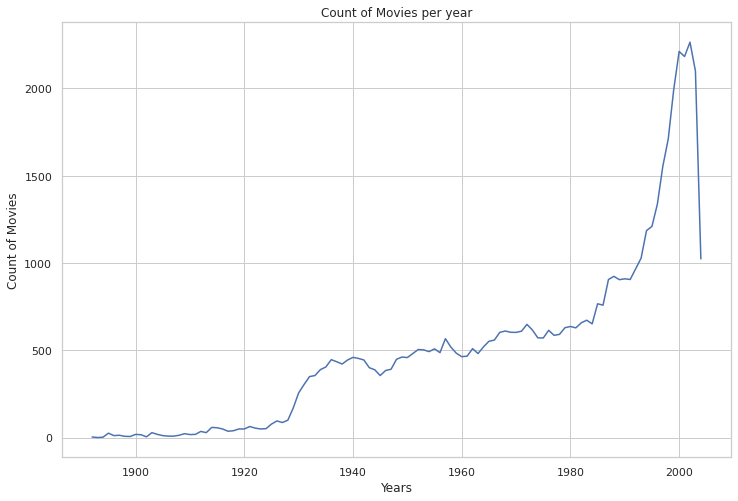

In [106]:
#Plot the total number of movies by year.
remove_duplicates = df_cleaned.drop_duplicates(["name"])
count_by_year = remove_duplicates.groupby('year')["name"].count()

def draw_linechart(df):
  #plot the chart of the data counts using seaborn 
  plt.title("Count of Movies per year")
  plt.xlabel("Years")
  plt.ylabel("Count of Movies")
  chart = sns.lineplot(data=df)
  sns.set_style("whitegrid")

draw_linechart(count_by_year)

I believe the tail-off at the end is due to the data being truncated by the source. Another dataset might yield more interesting results.


# Reflection
----

## What skills have you demonstrated in completing this notebook?

Initially, I worked with Jay on this mini project. We pulled together some of the previous worksheets on Pandas. We used dropping null values, filtering on columns and grouping by another. Plotting tools like pie charts and line graphs. Working with another person was helpful for me as I often can't get started quickly and sometimes can't see the typos or missing brackets easily.

**Update**: Returning to this project after a long break caused me minor issues as I wanted to expand on it and add more but the dataset was too limiting. If I had more time I would chose a larger and more detailed dataset to gain more interesting insights, like revenue data that might relate to the rankings of movies. Perhpas to find out who the top directors are for bringing movie producers the most revenue etc.


## What caused you the most difficulty?

Your answer: Jay and I worked together on this mini project, although Jay was well ahead of me when I started. It took me a while to catch up but Jay was patient and helped when I was really stuck. Mostly, I got stuck on syntax and what command to use sometimes. I struggled with the filtering functions still which is very frustrating to me. Future learning will help with the consolidation of this new knowledge.
